# **Denoiser approximation of a mathematical filter model (FIR and IIR case study)**

The goal is to show that a neural network can learn to approximate a filter's behaviour based on its time and frequency response analysis

## **Mathematical modelling of an FIR filter**

- Time domain representation:
$$ y[n] = \sum_{k=0}^{M-1} h[k] \cdot x[n-k] $$
where
- $y[n]$ is the output signal
- $x[n-k]$ is the input signal delayed by $k$ samples
- $h[k]$ is the filter coefficients
- $M$ is the number of coefficients

- Frequency domain representation: By taking the discrete time fourier transform (DTFT) of the impulse reponse $h[n]$:
$$ H(e^{j\omega}) = \sum_{k=0}^{M-1} h[k] \cdot e^{-j\omega k}$$


## **Neural Network Approximation of FIR filters**
Use of a 1D convolutional neural network (1D CNN) for FIR filters

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

import scipy.signal as signal

In [2]:
# a simple fir low pass filter using moving average
coeffs = np.array([1/3, 1/3, 1/3])
coeffs.shape

(3,)

Text(0, 0.5, 'Phase')

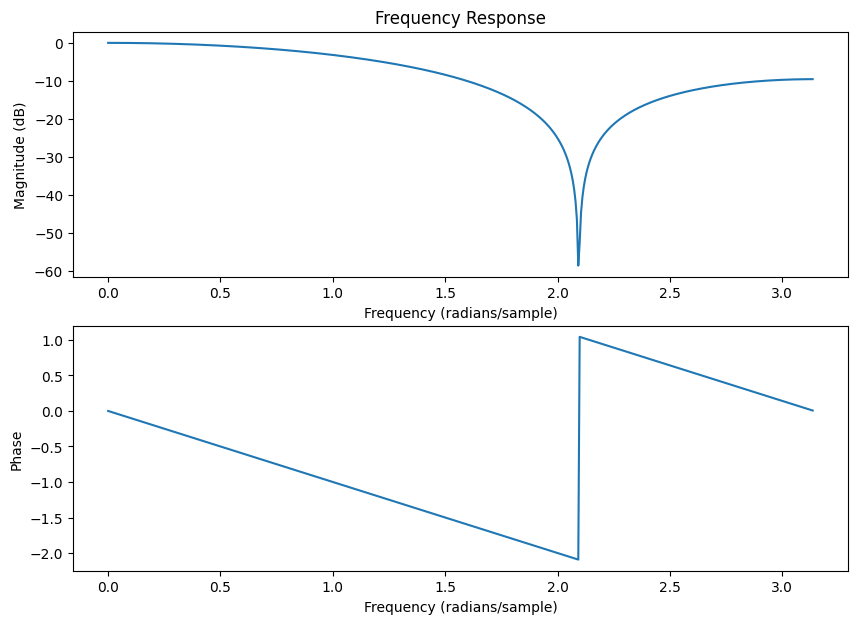

In [3]:
w, H = signal.freqz(coeffs)
H_db = 20*np.log10(np.abs(H))

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(2, 1, 1)
ax.plot(w, H_db)
ax.set_xlabel('Frequency (radians/sample)')
ax.set_ylabel('Magnitude (dB)')
ax.set_title('Frequency Response')

ax = fig.add_subplot(2, 1, 2)
ax.plot(w, np.arctan2(np.imag(H), np.real(H)))
ax.set_xlabel('Frequency (radians/sample)')
ax.set_ylabel('Phase')

In [4]:
# denoiser module is given by the following equations
# y = {0, if |x| <= tau, sgn(x) * (|x| - tau), otherwise}
# where tau is the threshold value given as 2 * beta
# beta is output of the global average pooling layer

class Denoiser(nn.Module):
    def __init__(self, seq_len=128):
        super(Denoiser, self).__init__()
        self.gap = nn.AvgPool1d(seq_len)
        self.bn = nn.BatchNorm1d(2)

    def forward(self, x):
        tau = 2 * F.sigmoid(self.bn(F.relu(self.gap(x))))
        y = torch.where(torch.abs(x) <= tau, torch.tensor(0.0),
                        torch.sign(x) * (torch.abs(x) - tau))
        return y

In [5]:
# toy data set
X_train = torch.randn(100, 2, 128)
y_train_i = torch.tensor(
    np.array([np.convolve(x[0], coeffs, mode='same') for x in X_train]))
y_train_q = torch.tensor(
    np.array([np.convolve(x[1], coeffs, mode='same') for x in X_train]))
y_train = torch.stack([y_train_i, y_train_q], dim=1).float()

X_val = torch.randn(30, 2, 128)
y_val_i = torch.tensor(
    np.array([np.convolve(x[0], coeffs, mode='same') for x in X_val]))
y_val_q = torch.tensor(
    np.array([np.convolve(x[1], coeffs, mode='same') for x in X_val]))
y_val = torch.stack([y_val_i, y_val_q], dim=1).float()

In [6]:
X_train.shape, y_train.shape

(torch.Size([100, 2, 128]), torch.Size([100, 2, 128]))

In [7]:
X_train.dtype, y_train.dtype

(torch.float32, torch.float32)

In [8]:
EPOCHS = 10000

In [9]:
model = Denoiser()
optim = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = nn.MSELoss()

model.train()
history = {'train_loss': [], 'val_loss': []}
for epoch in range(EPOCHS):
    optim.zero_grad()
    y_pred = model(X_train)
    loss = criterion(y_pred, y_train)
    loss.backward()
    optim.step()
    y_val_pred = model(X_val)
    val_loss = criterion(y_val_pred, y_val)
    print(
        f'Epoch {epoch+1}/{EPOCHS}, Loss: {loss.item():.4f}, Validation Loss: {val_loss.item():.4f}')
    history['train_loss'].append(loss.item())
    history['val_loss'].append(val_loss.item())

Epoch 1/10000, Loss: 0.2959, Validation Loss: 0.2965
Epoch 2/10000, Loss: 0.2951, Validation Loss: 0.2956
Epoch 3/10000, Loss: 0.2944, Validation Loss: 0.2948
Epoch 4/10000, Loss: 0.2936, Validation Loss: 0.2940
Epoch 5/10000, Loss: 0.2929, Validation Loss: 0.2932
Epoch 6/10000, Loss: 0.2922, Validation Loss: 0.2925
Epoch 7/10000, Loss: 0.2916, Validation Loss: 0.2918
Epoch 8/10000, Loss: 0.2909, Validation Loss: 0.2911
Epoch 9/10000, Loss: 0.2903, Validation Loss: 0.2904
Epoch 10/10000, Loss: 0.2897, Validation Loss: 0.2898
Epoch 11/10000, Loss: 0.2891, Validation Loss: 0.2891
Epoch 12/10000, Loss: 0.2885, Validation Loss: 0.2885
Epoch 13/10000, Loss: 0.2880, Validation Loss: 0.2880
Epoch 14/10000, Loss: 0.2874, Validation Loss: 0.2874
Epoch 15/10000, Loss: 0.2869, Validation Loss: 0.2869
Epoch 16/10000, Loss: 0.2865, Validation Loss: 0.2864
Epoch 17/10000, Loss: 0.2860, Validation Loss: 0.2859
Epoch 18/10000, Loss: 0.2856, Validation Loss: 0.2854
Epoch 19/10000, Loss: 0.2852, Validat

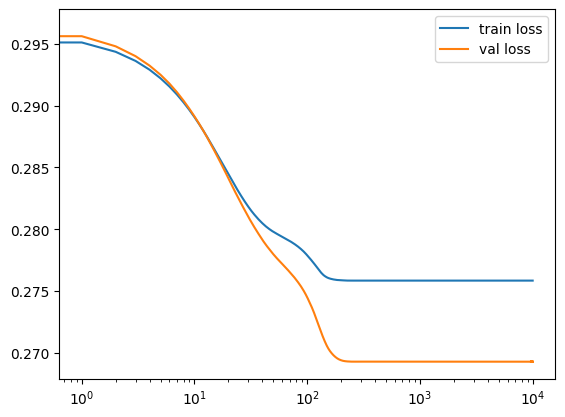

In [10]:
plt.semilogx(history['train_loss'], label='train loss')
plt.semilogx(history['val_loss'], label='val loss')
plt.legend()

## Data generation

We will test the idea of the ablation study of the denoiser module in the the TDRNN network proposed by [https://www.techrxiv.org/doi/pdf/10.36227/techrxiv.23632308.v1](https://www.techrxiv.org/doi/pdf/10.36227/techrxiv.23632308.v1) by observing the frequency reponse on these signals (qpsk and ofdm on qpsk symbols). These signal are defined by $\mathbb{C}^{40960}$

In [11]:
import tensorflow as tf

# local imports
import comm_utils as comm

2024-09-04 18:36:48.303527: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-04 18:36:48.303586: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-04 18:36:48.305418: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-04 18:36:48.315083: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-04 18:36:49.250208: W tensorflow/compiler/tf2

In [12]:
sps = 16
ofdm_symbol_len = 80  # 64 subcarriers + 16 cyclic prefix
sig_len = 40_960

In [13]:
def get_db(p): return 10*np.log10(p)
def get_pow(s): return np.mean(np.abs(s)**2, axis=-1)
def get_sinr(s, i): return get_pow(s)/get_pow(i)


def get_sinr_db(s, i): return get_db(get_sinr(s, i))


def generate_train_mixture(soi_type, nexamples):
    if soi_type == 'QPSK':
        gen_soi = comm.generate_qpsk_signal
        num_symbols = sig_len // sps
    elif soi_type == 'QPSK_OFDM':
        gen_soi = comm.generate_ofdm_signal
        num_symbols = sig_len // ofdm_symbol_len
    else:
        raise NotImplementedError

    sinr_db = tf.random.uniform(
        shape=(nexamples, 1), minval=-20, maxval=20, dtype=tf.float32)
    gain_linear = tf.pow(10.0, -0.5 * sinr_db / 10.0)
    gain_complex = tf.complex(gain_linear, tf.zeros_like(gain_linear))
    phase = tf.random.uniform(
        shape=(nexamples, 1), minval=-np.pi, maxval=np.pi, dtype=tf.float32)
    phase_complex = tf.complex(phase, tf.zeros_like(gain_linear))
    gain_phasor = gain_complex * tf.math.exp(1j * phase_complex)

    soi, msg_bits = gen_soi(nexamples, num_symbols)
    noise = tf.random.normal(
        shape=(nexamples, sig_len), mean=0.0, stddev=1.0)
    noise_complex = gain_phasor * tf.complex(noise, noise)
    sig_mixed = soi + noise_complex
    return dict(
        soi=soi,
        sig_mixed=sig_mixed,
        actual_sinr_db=get_sinr_db(soi, noise_complex),
        expected_sinr_db=sinr_db,
        msg_bits=msg_bits
    )

In [46]:
result = generate_train_mixture('QPSK', 10)

In [47]:
soi = result.get('soi').numpy()
sig_mixed = result.get('sig_mixed').numpy()
actual_sinr_db = result.get('actual_sinr_db')
expected_sinr_db = result.get('expected_sinr_db').numpy()
msg_bits = result.get('msg_bits').numpy()

In [48]:
soi.shape, sig_mixed.shape, actual_sinr_db.shape, expected_sinr_db.shape, msg_bits.shape

((10, 40960), (10, 40960), (10,), (10, 1), (10, 5120))

In [49]:
actual_sinr_db

array([-10.631508  , -11.0029125 ,  -9.509812  ,  -0.09600941,
         8.752385  ,   2.7272768 ,  -8.121856  ,   4.3096404 ,
        -8.755035  ,  -0.43698645], dtype=float32)

In [79]:
def plot_signal(soi, sig_mixed, fig=None):
    if fig is None:
        fig = plt.figure(figsize=(10, 5))
    ax = fig.add_subplot(2, 1, 1)
    ax.plot(sig_mixed.real, label='sig_mixed')
    ax.plot(soi.real, label='soi')
    ax.legend()
    ax.set_xlim(3000, 4024)

    ax = fig.add_subplot(2, 1, 2)
    signal_slices = torch.tensor(sig_mixed).unfold(0, 1024, 512)
    windowed_slices = signal_slices * torch.hann_window(1024)
    Sxx = torch.fft.fftshift(torch.fft.fft(windowed_slices, dim=-1), dim=-1)
    ax.imshow(10*torch.log10(torch.abs(Sxx)**2).T, aspect='auto')
    ax.set_xlabel('Time')
    ax.set_ylabel('Frequency')

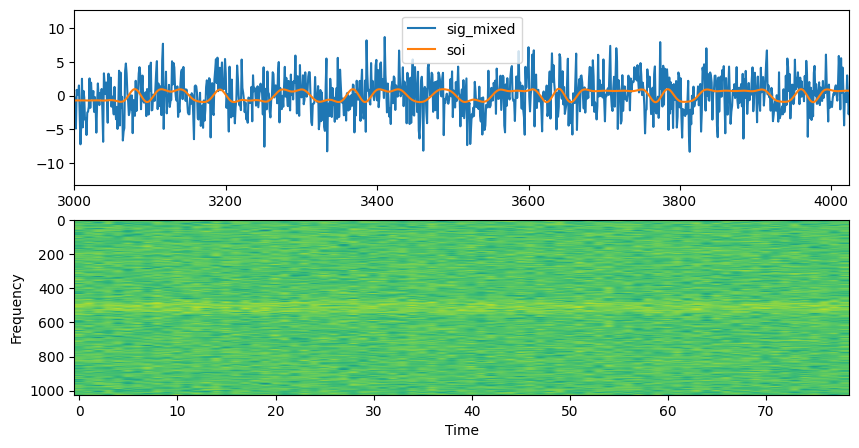

In [80]:
plot_signal(soi[2], sig_mixed[2])

In [20]:
from torch.utils.data import Dataset, DataLoader, random_split


class MixtureDataset(Dataset):
    def __init__(self, sig_mixed, soi, transform_mixed=None, transform_soi=None):
        self.sig_mixed = sig_mixed
        self.soi = soi
        self.transform_mixed = transform_mixed
        self.transform_soi = transform_soi

    def __len__(self):
        return len(self.sig_mixed)

    def __getitem__(self, idx):
        x = self.sig_mixed[idx]
        y = self.soi[idx]

        if self.transform_mixed:
            x = self.transform_mixed(x)
        elif isinstance(x, np.ndarray):
            x = torch.tensor(x)
        if self.transform_soi:
            y = self.transform_soi(y)
        elif isinstance(y, np.ndarray):
            y = torch.tensor(y)
        return x, y

In [21]:
from torchvision.transforms import Compose, Lambda

transform = Compose([
    Lambda(lambda x: torch.tensor(x, dtype=torch.complex64)),
    Lambda(lambda x: torch.stack([x.real, x.imag],
                                 axis=0) if x.dtype == torch.complex64 else x),
])

train_ds, val_ds = random_split(MixtureDataset(
    sig_mixed, soi, transform_mixed=transform, transform_soi=transform), [0.6, 0.4])

In [22]:
train_dl = DataLoader(train_ds, batch_size=32, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=32, shuffle=False)

In [23]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Denoiser(seq_len=40960).to(device)
optim = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = nn.MSELoss()
model.train()

history = {'train_loss': [], 'val_loss': []}

for epoch in range(EPOCHS):
    running_tloss = 0.0
    running_vloss = 0.0
    for x, y in train_dl:
        x, y = x.to(device), y.to(device)
        optim.zero_grad()
        y_pred = model(x)
        loss = criterion(y_pred, y)
        loss.backward()
        running_tloss += loss.item()
        optim.step()
    avg_tloss = running_tloss / len(train_dl)
    for x, y in val_dl:
        x, y = x.to(device), y.to(device)
        y_val_pred = model(x)
        val_loss = criterion(y_val_pred, y)
        running_vloss += val_loss.item()
    avg_vloss = running_vloss / len(val_dl)
    print(
        f'Epoch {epoch+1}/{EPOCHS}, Loss: {avg_tloss:.4f}, Validation Loss: {avg_vloss:.4f}')
    history['train_loss'].append(avg_tloss)
    history['val_loss'].append(avg_vloss)

Epoch 1/10000, Loss: 1.9751, Validation Loss: 2.8291
Epoch 2/10000, Loss: 1.9728, Validation Loss: 2.8215
Epoch 3/10000, Loss: 1.9704, Validation Loss: 2.8140
Epoch 4/10000, Loss: 1.9680, Validation Loss: 2.8064
Epoch 5/10000, Loss: 1.9657, Validation Loss: 2.7988
Epoch 6/10000, Loss: 1.9633, Validation Loss: 2.7911
Epoch 7/10000, Loss: 1.9609, Validation Loss: 2.7834
Epoch 8/10000, Loss: 1.9585, Validation Loss: 2.7757
Epoch 9/10000, Loss: 1.9560, Validation Loss: 2.7680
Epoch 10/10000, Loss: 1.9536, Validation Loss: 2.7602
Epoch 11/10000, Loss: 1.9511, Validation Loss: 2.7524
Epoch 12/10000, Loss: 1.9486, Validation Loss: 2.7446
Epoch 13/10000, Loss: 1.9461, Validation Loss: 2.7367
Epoch 14/10000, Loss: 1.9435, Validation Loss: 2.7287
Epoch 15/10000, Loss: 1.9409, Validation Loss: 2.7207
Epoch 16/10000, Loss: 1.9383, Validation Loss: 2.7127
Epoch 17/10000, Loss: 1.9356, Validation Loss: 2.7046
Epoch 18/10000, Loss: 1.9329, Validation Loss: 2.6965
Epoch 19/10000, Loss: 1.9302, Validat

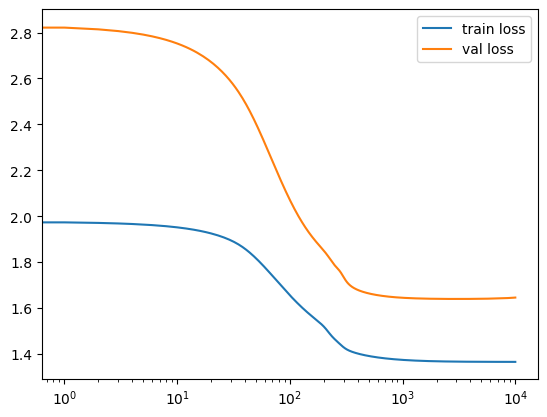

In [24]:
plt.semilogx(history['train_loss'], label='train loss')
plt.semilogx(history['val_loss'], label='val loss')
plt.legend()

## **Analysis of trained model**

In [25]:
model

Denoiser(
  (gap): AvgPool1d(kernel_size=(40960,), stride=(40960,), padding=(0,))
  (bn): BatchNorm1d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

In [28]:
'The model has ' + str(sum(p.numel() for p in model.parameters()
                       if p.requires_grad)) + ' parameters'

'The model has 4 parameters'

In [56]:
test_data = generate_train_mixture('QPSK', 5)
soi_test = test_data.get('soi').numpy()
sig_mixed_test = test_data.get('sig_mixed').numpy()
sinr_db_test = test_data.get('actual_sinr_db')
msg_bits_test = test_data.get('msg_bits').numpy()

In [57]:
soi_test.shape, sig_mixed_test.shape, sinr_db_test.shape, msg_bits_test.shape

((5, 40960), (5, 40960), (5,), (5, 5120))

In [58]:
sinr_db_test

array([ -4.3339834,  -4.055195 ,   2.601864 , -15.029604 , -16.469673 ],
      dtype=float32)

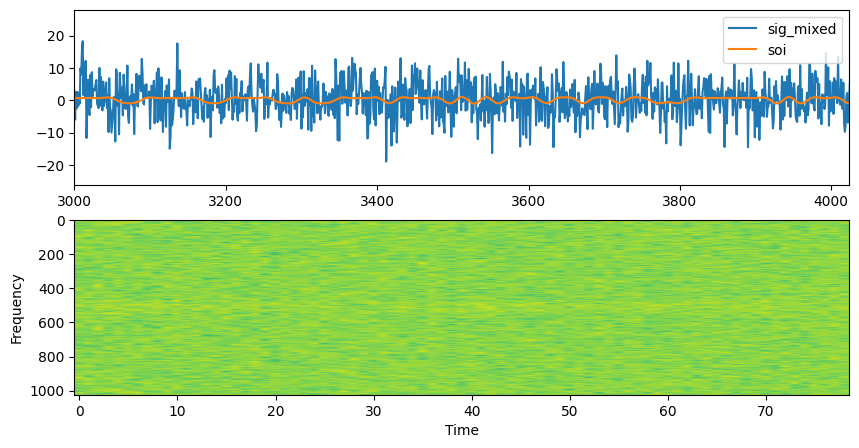

In [81]:
y, x = soi_test[3], sig_mixed_test[3]
plot_signal(y, x)

In [75]:
model.eval()

x_preprocessed = transform(x).unsqueeze(0).to(device)
y_hat = model(x_preprocessed).cpu().detach().numpy()
y_hat.shape

(1, 2, 40960)

(3000.0, 4024.0)

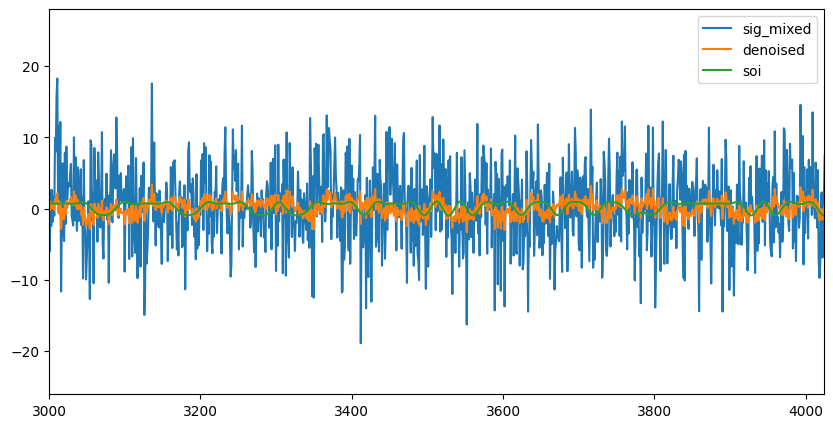

In [78]:
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(1, 1, 1)
ax.plot(x.real, label='sig_mixed')
ax.plot(y_hat[0][1], label='denoised')
ax.plot(y.real, label='soi')
ax.legend()
ax.set_xlim(3000, 4024)